In [1]:
from huggingface_hub import login
login("YOUR_HF_TOKEN")

import os, gc, json, random
from dataclasses import dataclass
from typing import Dict, List, Optional, Union

import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model


In [5]:
import os
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from tqdm import tqdm

# ============= Config =============
MODEL_REPO = "meta-llama/Llama-3.1-8B-Instruct"
LORA_ADAPTER = "Easonwangzk/lora-llama31-med-adapter"
DATA_PATH = "Rad_filtered_data_final_v5.csv"  # Path to your data
OUTPUT_PATH = "lora_comparison_results.csv"
NUM_SAMPLES = 10        # Number of test samples
MAX_NEW_TOKENS = 256    # Max generation length
MAX_SEQ_LEN = 512       # Max input length

# ============= Initialize tokenizer and models =============
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_REPO, use_fast=True)
tokenizer.padding_side = "left"

# Set pad token
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({"pad_token": "[PAD]"})

# Check bfloat16 support
use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
torch_dtype = torch.bfloat16 if use_bf16 else torch.float16

print(f"Loading base model: {MODEL_REPO}...")
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_REPO,
    torch_dtype=torch_dtype,
    device_map="auto",
)
base_model.config.pad_token_id = tokenizer.pad_token_id
base_model.eval()

print(f"Loading LoRA adapter: {LORA_ADAPTER}...")
lora_model = PeftModel.from_pretrained(base_model, LORA_ADAPTER)
lora_model.eval()

# ============= Generation function =============
@torch.no_grad()
def generate_answer(
    model,
    prompt: str,
    max_new_tokens: int = MAX_NEW_TOKENS,
    use_sampling: bool = True,
) -> str:
    """
    Generate an answer from the model.

    Args:
        model: The language model.
        prompt: Input prompt string.
        max_new_tokens: Maximum number of tokens to generate.
        use_sampling: Whether to use sampling (temperature + top_p) instead of greedy decoding.

    Returns:
        Generated answer text (content after 'Answer:').
    """
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_SEQ_LEN,
    )
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    gen_kwargs = {
        "max_new_tokens": max_new_tokens,
        "pad_token_id": tokenizer.pad_token_id,
    }

    if use_sampling:
        # Enable sampling so small logit differences between base and LoRA
        # lead to more noticeable differences in generated text.
        gen_kwargs.update(
            {
                "do_sample": True,
                "temperature": 0.7,
                "top_p": 0.9,
            }
        )
    else:
        gen_kwargs.update({"do_sample": False})

    outputs = model.generate(**inputs, **gen_kwargs)
    gen = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the part after "Answer:"
    return gen.split("Answer:")[-1].strip()


def create_prompt(impression: str) -> str:
    """
    Create a chat-style prompt for a radiology case.

    Args:
        impression: Radiology impression / report.

    Returns:
        Formatted prompt string.
    """
    messages = [
        {
            "role": "system",
            "content": (
                "You are an expert radiologist. Provide accurate, "
                "evidence-based answers using the provided medical context."
            ),
        },
        {
            "role": "user",
            "content": (
                f"Context:\n{impression}\n\n"
                "Question: What are the key findings in this case?\n\n"
                "Answer:"
            ),
        },
    ]
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )


# ============= Load data =============
print(f"\nLoading the first {NUM_SAMPLES} cases...")
df = pd.read_csv(DATA_PATH, nrows=NUM_SAMPLES)
print(f"Successfully loaded {len(df)} cases.\n")

# ============= Base model generation =============
print("=" * 60)
print("Generating answers with the base model...")
print("=" * 60)
base_answers = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Base model"):
    prompt = create_prompt(row["impression"])
    answer = generate_answer(base_model, prompt, use_sampling=True)
    base_answers.append(answer)

    # Optionally print the first two examples
    if idx < 2:
        print(f"\n--- Case {idx + 1} ---")
        print(f"Impression: {row['impression'][:100]}...")
        print(f"Base model answer: {answer[:200]}...\n")

# ============= LoRA model generation =============
print("\n" + "=" * 60)
print("Generating answers with the LoRA fine-tuned model...")
print("=" * 60)
lora_answers = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="LoRA model"):
    prompt = create_prompt(row["impression"])
    answer = generate_answer(lora_model, prompt, use_sampling=True)
    lora_answers.append(answer)

    # Optionally print the first two examples
    if idx < 2:
        print(f"\n--- Case {idx + 1} ---")
        print(f"Impression: {row['impression'][:100]}...")
        print(f"LoRA model answer: {answer[:200]}...\n")

# ============= Save results =============
results_df = df.copy()
results_df["base_model_answer"] = base_answers
results_df["lora_model_answer"] = lora_answers

results_df.to_csv(OUTPUT_PATH, index=False)
print("\n" + "=" * 60)
print(f"Results saved to: {OUTPUT_PATH}")
print("=" * 60)

# ============= Simple side-by-side comparison =============
print("\nSide-by-side comparison (first 2 cases):\n")
for idx in range(min(2, len(results_df))):
    print("=" * 60)
    print(f"Case {idx + 1}")
    print("=" * 60)
    print(f"Original impression:\n{results_df.iloc[idx]['impression']}\n")
    print(f"Base model answer:\n{results_df.iloc[idx]['base_model_answer']}\n")
    print(f"LoRA model answer:\n{results_df.iloc[idx]['lora_model_answer']}\n")

Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading base model: meta-llama/Llama-3.1-8B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading LoRA adapter: Easonwangzk/lora-llama31-med-adapter...

Loading the first 10 cases...
Successfully loaded 10 cases.

Generating answers with the base model...


Base model:  10%|█         | 1/10 [00:15<02:22, 15.88s/it]


--- Case 1 ---
Impression: Presurgical planning MRI shows a complex mass in the left cerebellar hemisphere with associated obst...
Base model answer: assistant

Key findings in this case include:

1. **Complex mass in the left cerebellar hemisphere**: This suggests a potentially space-occupying lesion that may be causing obstructive hydrocephalus.
...



Base model:  20%|██        | 2/10 [00:26<01:40, 12.50s/it]


--- Case 2 ---
Impression: 1. Postoperative findings with evidence of recurrent tumor in the left masticator, parapharyngeal, a...
Base model answer: assistant

The key findings in this case are:

1. Recurrent tumor in the left masticator, parapharyngeal, and pharyngeal mucosal spaces.
2. Erosion of the left mandible, posterior maxillary sinus wall...



Base model: 100%|██████████| 10/10 [02:05<00:00, 12.57s/it]



Generating answers with the LoRA fine-tuned model...


LoRA model:  10%|█         | 1/10 [00:18<02:49, 18.87s/it]


--- Case 1 ---
Impression: Presurgical planning MRI shows a complex mass in the left cerebellar hemisphere with associated obst...
LoRA model answer: assistant

Based on the provided context, the key findings in this case include:

1. **Complex mass in the left cerebellar hemisphere**: This indicates a possible tumor, vascular malformation, or radi...



LoRA model:  20%|██        | 2/10 [00:28<01:49, 13.72s/it]


--- Case 2 ---
Impression: 1. Postoperative findings with evidence of recurrent tumor in the left masticator, parapharyngeal, a...
LoRA model answer: assistant

The key findings in this case are:

1. Evidence of recurrent tumor in the left masticator, parapharyngeal, and pharyngeal mucosal spaces.
2. Erosion of the left mandible, posterior maxillar...



LoRA model: 100%|██████████| 10/10 [02:14<00:00, 13.46s/it]


Results saved to: lora_comparison_results.csv

Side-by-side comparison (first 2 cases):

Case 1
Original impression:
Presurgical planning MRI shows a complex mass in the left cerebellar hemisphere with associated obstructive hydrocephalus and a similar complex mass in the left temporo-occipital region. These lesions may represent radiation necrosis and perhaps vascular malformations with associated hemorrhage.

Base model answer:
assistant

Key findings in this case include:

1. **Complex mass in the left cerebellar hemisphere**: This suggests a potentially space-occupying lesion that may be causing obstructive hydrocephalus.
2. **Obstructive hydrocephalus**: This indicates that the mass in the cerebellar hemisphere is causing blockage of cerebrospinal fluid (CSF) pathways, leading to increased intracranial pressure and potential brain damage.
3. **Complex mass in the left temporo-occipital region**: This suggests another potentially space-occupying lesion that may be related to the c

In [ ]:
# 安装最新版本的所有依赖，避免版本冲突
!pip install --upgrade ragas
!pip install --upgrade langchain
!pip install --upgrade langchain-core
!pip install --upgrade langchain-openai
!pip install --upgrade openai
!pip install pandas numpy matplotlib seaborn datasets

# 验证安装
print("\n" + "="*60)
print("Verifying installations...")
print("="*60)

try:
    import ragas
    print(f"✓ RAGAS version: {ragas.__version__}")
except ImportError as e:
    print(f"✗ RAGAS import failed: {e}")

try:
    import openai
    print(f"✓ OpenAI version: {openai.__version__}")
except ImportError as e:
    print(f"✗ OpenAI import failed: {e}")

try:
    from langchain_openai import ChatOpenAI, OpenAIEmbeddings
    print(f"✓ langchain_openai installed")
except ImportError as e:
    print(f"✗ langchain_openai import failed: {e}")

try:
    from datasets import Dataset
    print(f"✓ datasets installed")
except ImportError as e:
    print(f"✗ datasets import failed: {e}")

print("="*60)

  Using cached ragas-0.3.9-py3-none-any.whl.metadata (22 kB)
  Using cached langchain_core-0.3.79-py3-none-any.whl.metadata (3.2 kB)
  Using cached langchain_text_splitters-0.3.11-py3-none-any.whl.metadata (1.8 kB)
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_community-0.4-py3-none-any.whl.metadata (3.0 kB)
  Using cached langchain_community-0.3.31-py3-none-any.whl.metadata (3.0 kB)
INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_openai-1.0.2-py3-none-any.whl.metadata (1.8 kB)
  Using cached langchain_openai-1.0.1-py3-none-any.whl.metadata (1.8 kB)
  Using cached langchain_openai-1.0.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached langchain_openai-0.3.35-py3-none-any.whl.metadata (2.4 kB)
Using cached ragas-0.3.9-py3-non

  Using cached langchain_core-1.0.5-py3-none-any.whl.metadata (3.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 6.4 MB/s eta 0:00:00
Using cached langchain_core-1.0.5-py3-none-any.whl (471 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 21.4 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", li

In [1]:
import pandas as pd
from datasets import Dataset

def prepare_ragas_dataset(df: pd.DataFrame, answer_column: str) -> Dataset:
    """
    准备RAGAS评估数据集

    医疗报告结构：
    - clinical_information: 患者临床信息（症状、病史等）
    - findings: 影像检查发现
    - impression: 影像学印象/诊断结论

    评估设置：
    - question: 构建明确的问题（基于临床信息生成诊断问题）
    - contexts: 提供findings作为上下文
    - answer: 模型生成的impression
    - ground_truth: 真实的impression
    """
    questions = []
    contexts = []

    for _, row in df.iterrows():
        # 构建明确的诊断问题
        clinical_info = str(row['clinical_information']).strip()
        findings = str(row['findings']).strip()

        # 创建更结构化的问题
        question = f"Based on the clinical information: {clinical_info}, what is the radiological impression?"

        # contexts应该是一个列表的列表，每个元素是一个context的列表
        context = [findings]  # 只使用findings作为上下文

        questions.append(question)
        contexts.append(context)

    data_dict = {
        'question': questions,
        'contexts': contexts,
        'answer': df[answer_column].fillna('').tolist(),
        'ground_truth': df['impression'].fillna('').tolist()
    }
    return Dataset.from_dict(data_dict)

# 读取单个CSV文件
comparison_df = pd.read_csv('lora_comparison_results.csv')

# 数据清洗：移除关键字段为空的行
print(f"Original dataset size: {len(comparison_df)}")

# 先填充NaN为空字符串，避免比较时出错
for col in ['clinical_information', 'findings', 'impression', 'base_model_answer', 'lora_model_answer']:
    if col in comparison_df.columns:
        comparison_df[col] = comparison_df[col].fillna('')

# 移除空值行
comparison_df = comparison_df[
    (comparison_df['clinical_information'].astype(str).str.strip() != '') &
    (comparison_df['findings'].astype(str).str.strip() != '') &
    (comparison_df['impression'].astype(str).str.strip() != '') &
    (comparison_df['base_model_answer'].astype(str).str.strip() != '') &
    (comparison_df['lora_model_answer'].astype(str).str.strip() != '')
]

print(f"Cleaned dataset size: {len(comparison_df)}")

if len(comparison_df) == 0:
    raise ValueError("No valid data after cleaning! Please check your CSV file.")

# 使用同一个DataFrame的不同列准备两个数据集
baseline_dataset = prepare_ragas_dataset(comparison_df, 'base_model_answer')
lora_dataset = prepare_ragas_dataset(comparison_df, 'lora_model_answer')

print("\nDatasets prepared for evaluation.")
print("\n=== Sample Data ===")
print(f"Question: {baseline_dataset[0]['question']}")
print(f"\nContexts: {baseline_dataset[0]['contexts']}")
print(f"\nBase Answer (first 200 chars): {baseline_dataset[0]['answer'][:200]}...")
print(f"\nGround Truth (first 200 chars): {baseline_dataset[0]['ground_truth'][:200]}...")

# 验证数据结构
print("\n=== Data Validation ===")
print(f"Number of samples: {len(baseline_dataset)}")
print(f"All questions non-empty: {all(len(q.strip()) > 0 for q in baseline_dataset['question'])}")
print(f"All contexts non-empty: {all(len(c[0].strip()) > 0 for c in baseline_dataset['contexts'])}")
print(f"All answers non-empty: {all(len(a.strip()) > 0 for a in baseline_dataset['answer'])}")
print(f"All ground_truths non-empty: {all(len(g.strip()) > 0 for g in baseline_dataset['ground_truth'])}")

Original dataset size: 10
Cleaned dataset size: 9

Datasets prepared for evaluation.

=== Sample Data ===
Question: Based on the clinical information: Preoperative planning for brain tumor. History of a left temporal AVM treated with radiation., what is the radiological impression?

Contexts: ['There is a heterogeneous left supratentorial and infratentorial lesion with associated cystic compartments, some of which contain fluid-fluid levels suggestive of hemorrhage. There is also surrounding vasogenic edema in the left cerebellar hemisphere. There is marked effacement of the fourth ventricle and dilatation of the third and fourth ventricles, which have increased in size slightly. There is also marked mass effect upon the brainstem. There is also a similar contiguous heterogeneous lesion within the left temporal and occipital lobes with surrounding vasogenic edema. There is no herniation. There are skin-based fiducial markers.']

Base Answer (first 200 chars): assistant

Key findings in

In [2]:
import os
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# 设置API密钥
os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"

# 配置RAGAS使用的LLM和Embeddings（最新版RAGAS的方式）
evaluator_llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
evaluator_embeddings = OpenAIEmbeddings()

print("✓ API Key configured")
print(f"✓ Evaluator LLM: {evaluator_llm.model_name}")
print(f"✓ Evaluator Embeddings: OpenAIEmbeddings")

✓ API Key configured
✓ Evaluator LLM: gpt-3.5-turbo
✓ Evaluator Embeddings: OpenAIEmbeddings


In [3]:
# 测试单个样本的评估，找出具体问题
from ragas import evaluate
from ragas.metrics import answer_correctness, answer_similarity, answer_relevancy

print("Testing individual metrics on a single sample...")
print("=" * 60)

# 创建只有一个样本的测试数据集
test_sample = Dataset.from_dict({
    'question': [baseline_dataset[0]['question']],
    'contexts': [baseline_dataset[0]['contexts']],
    'answer': [baseline_dataset[0]['answer']],
    'ground_truth': [baseline_dataset[0]['ground_truth']]
})

print("\nTest sample data:")
print(f"Question: {test_sample[0]['question'][:150]}...")
print(f"Answer length: {len(test_sample[0]['answer'])} chars")
print(f"Ground truth length: {len(test_sample[0]['ground_truth'])} chars")

# 逐个测试指标 - 使用最新RAGAS API
print("\n" + "=" * 60)
print("Testing Answer Similarity...")
try:
    result = evaluate(
        test_sample,
        metrics=[answer_similarity],
        llm=evaluator_llm,
        embeddings=evaluator_embeddings
    )
    print(f"✓ Answer Similarity: {result['answer_similarity']}")
except Exception as e:
    print(f"✗ Answer Similarity failed: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 60)
print("Testing Answer Correctness...")
try:
    result = evaluate(
        test_sample,
        metrics=[answer_correctness],
        llm=evaluator_llm,
        embeddings=evaluator_embeddings
    )
    print(f"✓ Answer Correctness: {result['answer_correctness']}")
except Exception as e:
    print(f"✗ Answer Correctness failed: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 60)
print("Testing Answer Relevancy...")
try:
    result = evaluate(
        test_sample,
        metrics=[answer_relevancy],
        llm=evaluator_llm,
        embeddings=evaluator_embeddings
    )
    print(f"✓ Answer Relevancy: {result['answer_relevancy']}")
except Exception as e:
    print(f"✗ Answer Relevancy failed: {e}")
    import traceback
    traceback.print_exc()

Testing individual metrics on a single sample...

Test sample data:
Question: Based on the clinical information: Preoperative planning for brain tumor. History of a left temporal AVM treated with radiation., what is the radiolog...
Answer length: 1058 chars
Ground truth length: 296 chars

Testing Answer Similarity...


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Answer Similarity: [0.9351945163381095]

Testing Answer Correctness...


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Answer Correctness: [0.8171319624178606]

Testing Answer Relevancy...


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Answer Relevancy: [np.float64(0.778722000581953)]


In [4]:
from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    answer_similarity,
    answer_relevancy
)

# evaluating the models using the RAGAS metrics.
def evaluate_model(dataset: Dataset, model_name: str):
    print(f"\nEvaluating {model_name}...")

    metrics = [
        answer_correctness,
        answer_similarity,
        answer_relevancy
    ]

    results = evaluate(
        dataset=dataset,
        metrics=metrics,
        llm=evaluator_llm,
        embeddings=evaluator_embeddings
    )

    return results


print("Running RAGAS evaluations with configured LLM...")
baseline_results = evaluate_model(baseline_dataset, "Base Model")
lora_results = evaluate_model(lora_dataset, "LoRA Model")

Running RAGAS evaluations with configured LLM...

Evaluating Base Model...


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]


Evaluating LoRA Model...


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]


--------------------------------------------------
BASELINE MODEL RESULTS
--------------------------------------------------
{'answer_correctness': 0.5706, 'answer_similarity': 0.9251, 'answer_relevancy': 0.8045}

--------------------------------------------------
Momento MODEL RESULTS
--------------------------------------------------
{'answer_correctness': 0.5903, 'answer_similarity': 0.9277, 'answer_relevancy': 0.8072}

--------------------------------------------------
Metrics comparison (mean scores)
--------------------------------------------------
            Metric  Baseline  Memento
Answer Correctness  0.570607 0.590324
 Answer Similarity  0.925140 0.927717
  Answer Relevancy  0.804457 0.807245

--------------------------------------------------
Detailed comparison with improvement.
--------------------------------------------------
            Metric  Baseline  Memento  Improvement (%)
Answer Correctness  0.570607 0.590324             3.46
 Answer Similarity  0.925140 0.927

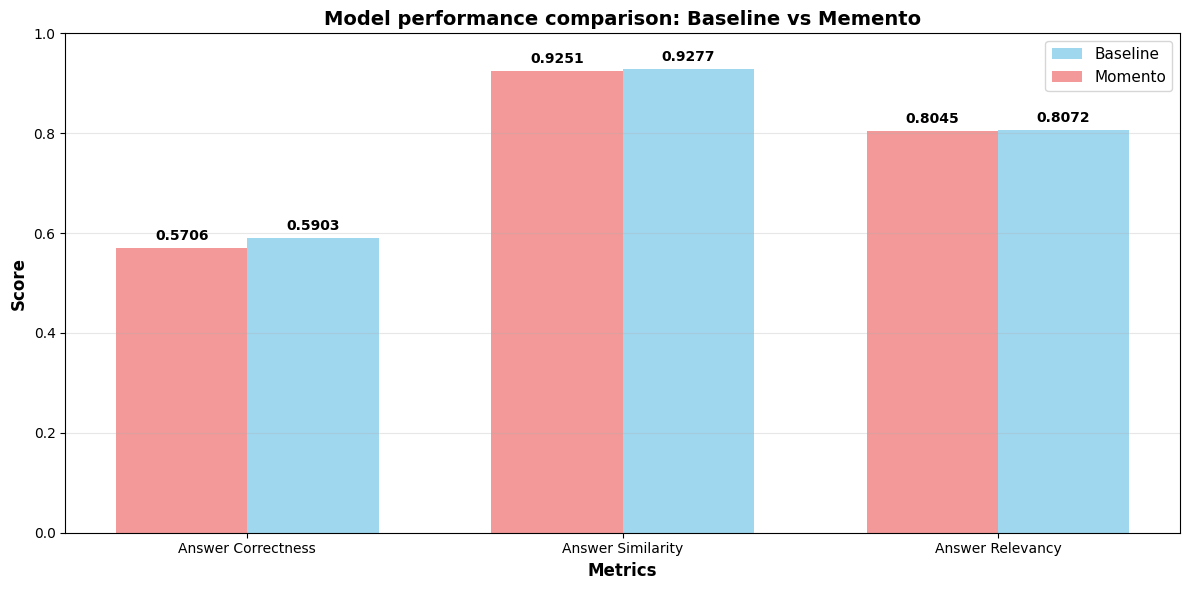

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


print("\n" + "-"*50)
print("BASELINE MODEL RESULTS")
print("-"*50)
print(lora_results)

print("\n" + "-"*50)
print("Momento MODEL RESULTS")
print("-"*50)
print(baseline_results)

# mean score.
def get_mean_score(results, metric_name):
    value = results[metric_name]
    if isinstance(value, list):
        return np.mean(value)
    return value

# comparing metrics by calculating the means.
metrics_comparison = pd.DataFrame({
    'Metric': ['Answer Correctness', 'Answer Similarity', 'Answer Relevancy'],
    'Baseline': [
        get_mean_score(lora_results, 'answer_correctness'),
        get_mean_score(lora_results, 'answer_similarity'),
        get_mean_score(lora_results, 'answer_relevancy')

    ],
    'Memento': [
        get_mean_score(baseline_results, 'answer_correctness'),
        get_mean_score(baseline_results, 'answer_similarity'),
        get_mean_score(baseline_results, 'answer_relevancy')
    ]
})

print("\n" + "-"*50)
print("Metrics comparison (mean scores)")
print("-"*50)
print(metrics_comparison.to_string(index=False))

# caluclating improvement.
metrics_comparison['Improvement (%)'] = ((metrics_comparison['Memento'] - metrics_comparison['Baseline']) / metrics_comparison['Baseline'] * 100).round(2)

print("\n" + "-"*50)
print("Detailed comparison with improvement.")
print("-"*50)
print(metrics_comparison.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(metrics_comparison))
width = 0.35

lora_bars = ax.bar([i + width/2 for i in x], metrics_comparison['Memento'],
                    width, label='Baseline', alpha=0.8, color='skyblue')
baseline_bars = ax.bar([i - width/2 for i in x], metrics_comparison['Baseline'],
                        width, label='Momento', alpha=0.8, color='lightcoral')


ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model performance comparison: Baseline vs Memento', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_comparison['Metric'], rotation=0, ha='center')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

for bars in [baseline_bars, lora_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
MEDQA_PATH    = "/medqa_50.json"
MEDMCQA_PATH  = "/medmcqa_50.json"
PUBMEDQA_PATH = "/pubmedqa_50.json"

MODEL_REPO = "meta-llama/Llama-3.1-8B-Instruct"
OUTPUT_DIR = "lora-med-eval-gpuonly"
USE_CHAT   = True

# micro-batch + grad accumulation.
BATCH_SIZE_TRAIN   = 1
BATCH_SIZE_EVAL    = 1
GRADIENT_ACC_STEPS = 8

# context length.
MAX_SEQ_LEN        = 384

# rraining hyperparams.
LR                 = 1e-4
NUM_EPOCHS         = 3
RANDOM_SEED        = 42
WEIGHT_DECAY       = 0.0
WARMUP_RATIO       = 0.03
LOGGING_STEPS      = 10
SAVE_TOTAL_LIMIT   = 1
EVAL_STRATEGY      = "no"

# LoRA config.
ULTRA_LOW_MEM      = False   # if True → r=8 and target=["q_proj","v_proj"]
LORA_R             = 8 if ULTRA_LOW_MEM else 16
LORA_ALPHA         = 16 if ULTRA_LOW_MEM else 32
LORA_DROPOUT       = 0.0
LORA_TARGET_MODULES= ["q_proj","v_proj"] if ULTRA_LOW_MEM else ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"]


os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True,max_split_size_mb:128")

'expandable_segments:True,max_split_size_mb:128'

In [ ]:
def bytes_to_gib(x): return x / (1024**3)

def assert_free_mem(min_gib_required: float):
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA is not available but GPU-only training was requested.")
    free, total = torch.cuda.mem_get_info()
    free_gib = bytes_to_gib(free)
    if free_gib < min_gib_required:
        raise RuntimeError(
            f"Not enough free GPU memory: {free_gib:.2f} GiB free, require ≥ {min_gib_required:.2f} GiB.\n"
            f"Tips to reduce memory WITHOUT CPU offload:\n"
            f"  - Decrease MAX_SEQ_LEN (e.g., 256 or 192)\n"
            f"  - Increase GRADIENT_ACC_STEPS (e.g., 16)\n"
            f"  - Set ULTRA_LOW_MEM=True (LoRA r=8, q/v only)\n"
            f"  - Ensure no other processes occupy GPU (nvidia-smi)\n"
        )

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

assert_free_mem(min_gib_required=10.0)

In [ ]:
# tokenizer.
tokenizer = AutoTokenizer.from_pretrained(MODEL_REPO, use_fast=True)
tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({"pad_token": "[PAD]"})

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
# model.
use_bf16 = torch.cuda.get_device_capability()[0] >= 8
torch_dtype = torch.bfloat16 if use_bf16 else torch.float16


model = AutoModelForCausalLM.from_pretrained(
    MODEL_REPO,
    device_map={"": "cuda:0"},
    torch_dtype=torch_dtype,
    low_cpu_mem_usage=False,
)


if tokenizer.pad_token_id is not None and tokenizer.pad_token_id >= model.config.vocab_size:
    model.resize_token_embeddings(len(tokenizer))


model.config.use_cache = False
try:
    model.config.attn_implementation = "sdpa"
except Exception:
    pass
# gradient checkpointing.
try:
    model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
except TypeError:
    model.gradient_checkpointing_enable()


In [ ]:
# data.
@dataclass
class MCItem:
    question: str
    options: Dict[str, str]
    answer_letter: str
    source_id: Optional[str] = None

@dataclass
class YesNoMaybeItem:
    question: str
    contexts: List[str]
    gold_label: str
    source_id: Optional[str] = None

def _read_json_any(path: str) -> Union[dict, list]:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def load_medqa(path: str) -> List[MCItem]:
    raw = _read_json_any(path); items=[]; bad=0
    it = raw.items() if isinstance(raw, dict) else enumerate(raw)
    for key, ex in it:
        q = str(ex.get("question","")).strip()
        opts_in = ex.get("options", {})
        opts = {k.upper(): str(v) for k,v in opts_in.items() if k.upper() in ["A","B","C","D","E"]}
        if len(opts) < 2: bad+=1; continue
        ans = str(ex.get("answer_idx", ex.get("answer",""))).strip().upper()
        if ans not in opts:
            inv = {v.strip(): k for k,v in opts.items()}
            ans = inv.get(ans,"")
        if ans not in opts: bad+=1; continue
        items.append(MCItem(q, opts, ans, str(key)))
    if bad: print(f"[MedQA] skipped {bad} malformed item(s). Using {len(items)}.")
    return items

def load_medmcqa(path: str) -> List[MCItem]:
    raw = _read_json_any(path); items=[]; bad=0
    idx_to_letter = {1:"A",2:"B",3:"C",4:"D",5:"E"}; strnum = {"1":"A","2":"B","3":"C","4":"D","5":"E"}
    it = raw.items() if isinstance(raw, dict) else enumerate(raw)
    for key, ex in it:
        q = str(ex.get("question","")).strip(); opts={}
        if isinstance(ex.get("options"), dict):
            for k,v in ex["options"].items():
                kk = str(k).strip().upper()
                if kk in ["A","B","C","D","E"]: opts[kk]=str(v)
        else:
            for L,fld in {"A":"opa","B":"opb","C":"opc","D":"opd","E":"ope"}.items():
                if fld in ex and ex[fld] is not None: opts[L]=str(ex[fld])
        if len(opts) < 2 or not q: bad+=1; continue
        gold_raw = ex.get("cop", ex.get("answer_idx", ex.get("answer", ex.get("label",""))))
        if isinstance(gold_raw,int): gold = idx_to_letter.get(gold_raw,"")
        else:
            s = str(gold_raw).strip()
            if s in strnum: gold=strnum[s]
            elif len(s)==1 and s.lower() in "abcde": gold=s.upper()
            elif s.upper() in ["A","B","C","D","E"]: gold=s.upper()
            else:
                inv={v.strip():k for k,v in opts.items()}; gold=inv.get(s,"")
        if gold not in opts: bad+=1; continue
        items.append(MCItem(q,opts,gold,str(key)))
    if bad: print(f"[MedMCQA] skipped {bad} malformed item(s). Using {len(items)}.")
    return items

def load_pubmedqa(path: str) -> List[YesNoMaybeItem]:
    raw = _read_json_any(path); items=[]; bad=0
    it = raw.items() if isinstance(raw, dict) else enumerate(raw)
    for key, ex in it:
        q = str(ex.get("QUESTION", ex.get("question",""))).strip()
        ctx = ex.get("CONTEXTS", ex.get("contexts", []))
        if not isinstance(ctx, list): ctx=[str(ctx)]
        gold = str(ex.get("final_decision", ex.get("answer",""))).strip().lower()
        if gold not in {"yes","no","maybe"}: bad+=1; continue
        items.append(YesNoMaybeItem(q, [str(c) for c in ctx], gold, str(key)))
    if bad: print(f"[PubMedQA] skipped {bad} malformed item(s). Using {len(items)}.")
    return items

class AnswerOnlySFTDataset(Dataset):
    def __init__(self, mc_items: List[MCItem], ynm_items: List[YesNoMaybeItem], split="train", split_ratio=0.8):
        rng = random.Random(RANDOM_SEED)
        mc = mc_items[:]; ynm = ynm_items[:]; rng.shuffle(mc); rng.shuffle(ynm)
        mc_cut = int(len(mc)*split_ratio); ynm_cut = int(len(ynm)*split_ratio)
        if split=="train": self.mc=mc[:mc_cut]; self.ynm=ynm[:ynm_cut]
        else: self.mc=mc[mc_cut:]; self.ynm=ynm[ynm_cut:]
        self.examples=[]
        for it in self.mc:
            letters="".join(sorted(it.options.keys()))
            opts="\n".join([f"{k}. {v}" for k,v in it.options.items()])
            user=("You are answering a multiple-choice medical question.\n"
                  "Return ONLY one uppercase letter.\n\n"
                  f"Question:\n{it.question}\n\nOptions:\n{opts}\n\n"
                  f"Answer with ONLY ONE LETTER from [{letters}].\nAnswer:")
            self.examples.append(("mc", user, it.answer_letter))
        for it in self.ynm:
            ctx="\n".join(f"- {c}" for c in it.contexts[:6])
            user=("You are assessing a biomedical yes/no/maybe question.\n"
                  "Return ONLY one token: yes, no, or maybe (lowercase).\n\n"
                  f"Question:\n{it.question}\n\nEvidence:\n{ctx}\n\nAnswer:")
            self.examples.append(("ynm", user, it.gold_label))
        rng.shuffle(self.examples)

    def __len__(self): return len(self.examples)

    def __getitem__(self, idx):
        _task, user_msg, ans = self.examples[idx]
        msgs=[{"role":"user","content":user_msg},{"role":"assistant","content":ans}]
        text = tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=False)
        enc = tokenizer(text, return_tensors="pt", padding=False, truncation=True, max_length=MAX_SEQ_LEN)
        input_ids = enc["input_ids"][0]
        labels = input_ids.clone()
        ans_ids = tokenizer(ans, add_special_tokens=False)["input_ids"]
        N = len(ans_ids)
        keep = N + 1 if len(labels) >= N + 1 else N
        labels[:] = -100
        labels[-keep:] = input_ids[-keep:]
        return {"input_ids": input_ids, "attention_mask": enc["attention_mask"][0], "labels": labels}

# building the datasets.
medqa_items    = load_medqa(MEDQA_PATH)
medmcqa_items  = load_medmcqa(MEDMCQA_PATH)
pubmedqa_items = load_pubmedqa(PUBMEDQA_PATH)
train_ds = AnswerOnlySFTDataset(medqa_items+medmcqa_items, pubmedqa_items, split="train", split_ratio=0.8)
val_ds   = AnswerOnlySFTDataset(medqa_items+medmcqa_items, pubmedqa_items, split="val",   split_ratio=0.8)

In [ ]:
class CausalLMAnswerOnlyCollator:
    def __init__(self, tokenizer):
        self.tk = tokenizer
        self.pad_id = tokenizer.pad_token_id
    def __call__(self, features):
        input_ids  = [f["input_ids"] for f in features]
        attn_mask  = [f["attention_mask"] for f in features]
        labels     = [f["labels"] for f in features]
        input_ids  = pad_sequence(input_ids, batch_first=True, padding_value=self.pad_id)
        attn_mask  = pad_sequence(attn_mask, batch_first=True, padding_value=0)
        max_len = input_ids.size(1)
        padded=[]
        for y in labels:
            pad_len = max_len - y.size(0)
            if pad_len > 0:
                y = torch.cat([y, torch.full((pad_len,), -100, dtype=y.dtype, device=y.device)])
            padded.append(y)
        labels = torch.stack(padded, dim=0)
        return {"input_ids": input_ids, "attention_mask": attn_mask, "labels": labels}

collator = CausalLMAnswerOnlyCollator(tokenizer)

In [ ]:
# LoRA.
peft_config = LoraConfig(
    r=LORA_R, lora_alpha=LORA_ALPHA, lora_dropout=LORA_DROPOUT,
    target_modules=LORA_TARGET_MODULES, bias="none", task_type="CAUSAL_LM"
)
lora_model = get_peft_model(model, peft_config)


try:
    lora_model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
except TypeError:
    lora_model.gradient_checkpointing_enable()

In [ ]:
# training.

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE_TRAIN,
    per_device_eval_batch_size=BATCH_SIZE_EVAL,
    gradient_accumulation_steps=GRADIENT_ACC_STEPS,
    fp16=(not use_bf16),
    bf16=use_bf16,
    logging_steps=LOGGING_STEPS,
    eval_strategy=EVAL_STRATEGY,
    save_strategy="epoch",
    save_total_limit=SAVE_TOTAL_LIMIT,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="cosine",
    report_to="none",
    no_cuda=False,
)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds if EVAL_STRATEGY != "no" else None,
    data_collator=collator,
)

print("Starting LoRA fine-tuning on GPU only.")
trainer.train()
print("Training done.")
trainer.save_model(OUTPUT_DIR)
print(f"LoRA adapters saved to: {OUTPUT_DIR}")

# from huggingface_hub import HfApi, create_repo
# import os


# HF_TOKEN = "YOUR_HF_TOKEN"

# REPO_ID = "Easonwangzk/lora-llama31-med-adapter"

# OUTPUT_DIR = "lora-med-eval-gpuonly"

# if not HF_TOKEN:
#     raise RuntimeError("HF_TOKEN is empty. Set it via environment variable or hardcode the string.")

# create_repo(repo_id=REPO_ID, repo_type="model", exist_ok=True, token=HF_TOKEN)

# api = HfApi()
# api.upload_folder(
#     folder_path=OUTPUT_DIR,
#     repo_id=REPO_ID,
#     token=HF_TOKEN,
#     repo_type="model",
# )

# print(f"Uploaded to: https://huggingface.co/{REPO_ID}")

import os, json, re
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from tqdm import tqdm

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting LoRA fine-tuning on GPU only.


Step,Training Loss
10,1.550100
20,0.915300
30,0.760200
40,0.473900


Training done.
LoRA adapters saved to: lora-med-eval-gpuonly


In [ ]:
# config.

MEDQA_PATH    = "medqa_50.json"
MEDMCQA_PATH  = "medmcqa_50.json"
PUBMEDQA_PATH = "pubmedqa_50.json"

MODEL_REPO = "meta-llama/Llama-3.1-8B-Instruct"
USE_CHAT   = True

# ICL shots.
K_SHOTS_MC   = 0
K_SHOTS_YNM  = 0
BALANCE_LABELS = True
RANDOM_SEED  = 42
MAX_SEQ_LEN  = 1024

ADAPTER_REPO_OR_PATH = "lora-med-eval-gpuonly"


# dtypes and tokenizer/model.
use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
torch_dtype = torch.bfloat16 if use_bf16 else torch.float16


tokenizer = AutoTokenizer.from_pretrained(MODEL_REPO, use_fast=True)
tokenizer.padding_side = "left"

pad_added = False
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({"pad_token": "[PAD]"})
        pad_added = True

# loading the base model.
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_REPO,
    torch_dtype=torch_dtype,
    device_map="auto",
)
if pad_added:
    base_model.resize_token_embeddings(len(tokenizer))


base_model.config.pad_token_id = tokenizer.pad_token_id
base_model.eval()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
  

In [ ]:
# data containers and loaders.
@dataclass
class MCItem:
    question: str
    options: Dict[str, str]
    answer_letter: str
    source_id: Optional[str] = None

@dataclass
class YesNoMaybeItem:
    question: str
    contexts: List[str]
    gold_label: str
    source_id: Optional[str] = None

def _read_json_any(path: str) -> Union[dict, list]:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def load_medqa(path: str) -> List[MCItem]:
    raw = _read_json_any(path)
    items: List[MCItem] = []
    bad = 0
    iterator = raw.items() if isinstance(raw, dict) else enumerate(raw)
    for key, ex in iterator:
        q = str(ex.get("question", "")).strip()
        opts_in = ex.get("options", {})
        opts = {k.upper(): str(v) for k, v in opts_in.items() if k.upper() in ["A","B","C","D","E"]}
        if len(opts) < 2:
            bad += 1; continue
        ans = ex.get("answer_idx", ex.get("answer", ""))
        ans = str(ans).strip().upper()
        if ans not in opts:
            inv = {v.strip(): k for k, v in opts.items()}
            ans = inv.get(ans, "")
        if ans not in opts:
            bad += 1; continue
        items.append(MCItem(q, opts, ans, str(key)))
    if bad: print(f"[MedQA] skipped {bad} malformed item(s). Using {len(items)}.")
    return items

def load_medmcqa(path: str) -> List[MCItem]:
    raw = _read_json_any(path)
    items: List[MCItem] = []
    bad = 0
    idx_to_letter = {1:"A",2:"B",3:"C",4:"D",5:"E"}
    strnum_to_letter = {"1":"A","2":"B","3":"C","4":"D","5":"E"}
    iterator = raw.items() if isinstance(raw, dict) else enumerate(raw)
    for key, ex in iterator:
        q = str(ex.get("question","")).strip()
        opts = {}
        if isinstance(ex.get("options"), dict):
            for k, v in ex["options"].items():
                kk = str(k).strip().upper()
                if kk in ["A","B","C","D","E"]:
                    opts[kk] = str(v)
        else:
            for L, fld in {"A":"opa","B":"opb","C":"opc","D":"opd","E":"ope"}.items():
                if fld in ex and ex[fld] is not None:
                    opts[L] = str(ex[fld])
        if len(opts) < 2 or not q:
            bad += 1; continue
        gold_raw = ex.get("cop", ex.get("answer_idx", ex.get("answer", ex.get("label",""))))
        gold = ""
        if isinstance(gold_raw, int):
            gold = idx_to_letter.get(gold_raw, "")
        else:
            s = str(gold_raw).strip()
            if s in strnum_to_letter:
                gold = strnum_to_letter[s]
            elif len(s)==1 and s.lower() in "abcde":
                gold = s.upper()
            elif s.upper() in ["A","B","C","D","E"]:
                gold = s.upper()
            else:
                inv = {v.strip(): k for k, v in opts.items()}
                gold = inv.get(s, "")
        if gold not in opts:
            bad += 1; continue
        items.append(MCItem(q, opts, gold, str(key)))
    if bad: print(f"[MedMCQA] skipped {bad} malformed item(s). Using {len(items)}.")
    return items

def load_pubmedqa(path: str) -> List[YesNoMaybeItem]:
    raw = _read_json_any(path)
    items: List[YesNoMaybeItem] = []
    bad = 0
    iterator = raw.items() if isinstance(raw, dict) else enumerate(raw)
    for key, ex in iterator:
        q = str(ex.get("QUESTION", ex.get("question",""))).strip()
        ctx = ex.get("CONTEXTS", ex.get("contexts", []))
        if not isinstance(ctx, list):
            ctx = [str(ctx)]
        gold = str(ex.get("final_decision", ex.get("answer",""))).strip().lower()
        if gold not in {"yes","no","maybe"}:
            bad += 1; continue
        items.append(YesNoMaybeItem(q, [str(c) for c in ctx], gold, str(key)))
    if bad: print(f"[PubMedQA] skipped {bad} malformed item(s). Using {len(items)}.")
    return items


In [ ]:
# prompting (zero-shot and ICL).
def apply_chat_template(user_msg: str, system_msg: str = "") -> str:
    msgs = []
    if system_msg:
        msgs.append({"role":"system","content":system_msg})
    msgs.append({"role":"user","content":user_msg})
    return tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)

def mc_prompt(item: MCItem) -> str:
    letters = "".join(sorted(item.options.keys()))
    opts = "\n".join([f"{k}. {v}" for k, v in item.options.items()])
    user = (
        "You are answering a multiple-choice medical question.\n"
        "Return ONLY one uppercase letter.\n\n"
        f"Question:\n{item.question}\n\nOptions:\n{opts}\n\n"
        f"Answer with ONLY ONE LETTER from [{letters}].\nAnswer:"
    )
    return apply_chat_template(user) if USE_CHAT else user

def pubmedqa_prompt(item: YesNoMaybeItem) -> str:
    ctx = "\n".join(f"- {c}" for c in item.contexts[:6])
    user = (
        "You are assessing a biomedical yes/no/maybe question.\n"
        "Return ONLY one token: yes, no, or maybe (lowercase).\n\n"
        f"Question:\n{item.question}\n\nEvidence:\n{ctx}\n\nAnswer:"
    )
    return apply_chat_template(user) if USE_CHAT else user

# ICL helpers
rng = torch.Generator().manual_seed(RANDOM_SEED)

def sample_fewshot_mc(pool: List[MCItem], k: int, avoid_key: Optional[str]=None) -> List[MCItem]:
    if not pool or k <= 0: return []
    cand = [it for it in pool if it.source_id != avoid_key]
    if not BALANCE_LABELS:
        idx = torch.randperm(len(cand), generator=rng).tolist()[:k]
        return [cand[i] for i in idx]
    by_label = {}
    for it in cand:
        by_label.setdefault(it.answer_letter, []).append(it)
    for lab in by_label:
        idx = torch.randperm(len(by_label[lab]), generator=rng).tolist()
        by_label[lab] = [by_label[lab][i] for i in idx]
    out, ptr = [], {lab:0 for lab in by_label}
    labs = sorted(by_label.keys())
    while len(out) < min(k, len(cand)) and labs:
        for lab in list(labs):
            if ptr[lab] < len(by_label[lab]) and len(out) < k:
                out.append(by_label[lab][ptr[lab]]); ptr[lab] += 1
            if ptr[lab] >= len(by_label[lab]): labs.remove(lab)
    return out

def sample_fewshot_ynm(pool: List[YesNoMaybeItem], k: int, avoid_key: Optional[str]=None) -> List[YesNoMaybeItem]:
    if not pool or k <= 0: return []
    cand = [it for it in pool if it.source_id != avoid_key]
    by_label = {}
    for it in cand:
        by_label.setdefault(it.gold_label, []).append(it)
    for lab in by_label:
        idx = torch.randperm(len(by_label[lab]), generator=rng).tolist()
        by_label[lab] = [by_label[lab][i] for i in idx]
    out, ptr = [], {lab:0 for lab in by_label}
    labs = sorted(by_label.keys())
    while len(out) < min(k, len(cand)) and labs:
        for lab in list(labs):
            if ptr[lab] < len(by_label[lab]) and len(out) < k:
                out.append(by_label[lab][ptr[lab]]); ptr[lab] += 1
            if ptr[lab] >= len(by_label[lab]): labs.remove(lab)
    return out

def apply_chat_template_icl(demos: List[Tuple[str, str]], user_msg: str, system_msg: str = "") -> str:
    msgs = []
    if system_msg:
        msgs.append({"role":"system","content":system_msg})
    for du, da in demos:
        msgs.append({"role":"user","content":du})
        msgs.append({"role":"assistant","content":da})
    msgs.append({"role":"user","content":user_msg})
    return tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)

def mc_prompt_icl(item: MCItem, pool: List[MCItem], k: int) -> str:
    demos_items = sample_fewshot_mc(pool, k, avoid_key=item.source_id)
    demos = []
    for d in demos_items:
        letters = "".join(sorted(d.options.keys()))
        opts = "\n".join([f"{k}. {v}" for k, v in d.options.items()])
        du = (
            "You are answering a multiple-choice medical question.\n"
            "Return ONLY one uppercase letter.\n\n"
            f"Question:\n{d.question}\n\nOptions:\n{opts}\n\n"
            f"Answer with ONLY ONE LETTER from [{letters}].\nAnswer:"
        )
        demos.append((du, d.answer_letter))
    letters = "".join(sorted(item.options.keys()))
    opts = "\n".join([f"{k}. {v}" for k, v in item.options.items()])
    user = (
        "You are answering a multiple-choice medical question.\n"
        "Return ONLY one uppercase letter.\n\n"
        f"Question:\n{item.question}\n\nOptions:\n{opts}\n\n"
        f"Answer with ONLY ONE LETTER from [{letters}].\nAnswer:"
    )
    return apply_chat_template_icl(demos, user)

def pubmedqa_prompt_icl(item: YesNoMaybeItem, pool: List[YesNoMaybeItem], k: int) -> str:
    demos_items = sample_fewshot_ynm(pool, k, avoid_key=item.source_id)
    demos = []
    for d in demos_items:
        ctx = "\n".join(f"- {c}" for c in d.contexts[:6])
        du = (
            "You are assessing a biomedical yes/no/maybe question.\n"
            "Return ONLY one token: yes, no, or maybe (lowercase).\n\n"
            f"Question:\n{d.question}\n\nEvidence:\n{ctx}\n\nAnswer:"
        )
        demos.append((du, d.gold_label))
    ctx = "\n".join(f"- {c}" for c in item.contexts[:6])
    user = (
        "You are assessing a biomedical yes/no/maybe question.\n"
        "Return ONLY one token: yes, no, or maybe (lowercase).\n\n"
        f"Question:\n{item.question}\n\nEvidence:\n{ctx}\n\nAnswer:"
    )
    return apply_chat_template_icl(demos, user)


In [ ]:
# generation, parsing and evaluation.

@torch.no_grad()
def generate_answer(model, prompt: str, max_new_tokens: int = 24) -> str:
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=MAX_SEQ_LEN)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.pad_token_id,
    )
    gen = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return gen.split("Answer:")[-1].strip()

LETTER_RE = re.compile(r"\b([A-E])\b")
YNM_RE    = re.compile(r"\b(yes|no|maybe)\b", re.IGNORECASE)

def parse_mc_letter(text: str, allowed: List[str]) -> Optional[str]:
    m = LETTER_RE.search(text.upper())
    if not m: return None
    cand = m.group(1)
    return cand if cand in allowed else None

def parse_ynm(text: str) -> Optional[str]:
    m = YNM_RE.search(text)
    return m.group(1).lower() if m else None

def eval_mcq(model, items: List[MCItem], desc: str,
             icl_pool: Optional[List[MCItem]]=None, k_shots: int=0) -> float:
    correct, used = 0, 0
    for it in tqdm(items, desc=desc, ncols=80):
        prompt = mc_prompt_icl(it, icl_pool, k=k_shots) if (k_shots>0 and icl_pool) else mc_prompt(it)
        out = generate_answer(model, prompt)
        allowed = sorted(list(it.options.keys()))
        pred = parse_mc_letter(out, allowed) or ""
        used += 1; correct += int(pred == it.answer_letter)
    return correct / max(1, used)

def eval_pubmedqa(model, items: List[YesNoMaybeItem], desc: str,
                  icl_pool: Optional[List[YesNoMaybeItem]]=None, k_shots: int=0) -> float:
    correct, used = 0, 0
    for it in tqdm(items, desc=desc, ncols=80):
        prompt = pubmedqa_prompt_icl(it, icl_pool, k=k_shots) if (k_shots>0 and icl_pool) else pubmedqa_prompt(it)
        out = generate_answer(model, prompt)
        pred = parse_ynm(out) or ""
        used += 1; correct += int(pred == it.gold_label)
    return correct / max(1, used)

def run_full_eval(tag: str, model) -> Tuple[float, float, float, float]:
    medqa_items    = load_medqa(MEDQA_PATH)
    medmcqa_items  = load_medmcqa(MEDMCQA_PATH)
    pubmedqa_items = load_pubmedqa(PUBMEDQA_PATH)

    medqa_pool    = medqa_items
    medmcqa_pool  = medmcqa_items
    pubmedqa_pool = pubmedqa_items

    medqa_acc    = eval_mcq(model, medqa_items,   f"[{tag}] MedQA (k={K_SHOTS_MC})",     icl_pool=medqa_pool,   k_shots=K_SHOTS_MC)
    medmcqa_acc  = eval_mcq(model, medmcqa_items, f"[{tag}] MedMCQA (k={K_SHOTS_MC})",   icl_pool=medmcqa_pool, k_shots=K_SHOTS_MC)
    pubmedqa_acc = eval_pubmedqa(model, pubmedqa_items, f"[{tag}] PubMedQA (k={K_SHOTS_YNM})", icl_pool=pubmedqa_pool, k_shots=K_SHOTS_YNM)
    macro = (medqa_acc + medmcqa_acc + pubmedqa_acc) / 3.0

    print(f"\n[{tag}] MedQA acc:    {medqa_acc:.3f}")
    print(f"[{tag}] MedMCQA acc:  {medmcqa_acc:.3f}")
    print(f"[{tag}] PubMedQA acc: {pubmedqa_acc:.3f}")
    print("-"*60)
    print(f"[{tag}] Macro-average: {macro:.3f}\n")
    return medqa_acc, medmcqa_acc, pubmedqa_acc, macro

In [ ]:
# evaluating the base and local LoRA models.

print("\n--- Evaluating the Base model ---")
_ = run_full_eval("BASE", base_model)

if ADAPTER_REPO_OR_PATH:
    cfg_path = os.path.join(ADAPTER_REPO_OR_PATH, "adapter_config.json")
    if not os.path.exists(cfg_path):
        raise FileNotFoundError(
            f"adapter_config.json not found in '{ADAPTER_REPO_OR_PATH}'. "
            f"Ensure this is your trained OUTPUT_DIR with LoRA files."
        )
    print("\n---- Loading the local LoRa adapters ---")
    lora_model = PeftModel.from_pretrained(base_model, ADAPTER_REPO_OR_PATH)
    lora_model.eval()
    print("--- Evaluating the LoRa model ---")
    _ = run_full_eval("LoRA", lora_model)
else:
    print("No adapters specified, skipped LoRA evaluation.")


print("\n--- Evaluating on the first 10 samples ---")

print("Loading first 10 cases.")
import pandas as pd
df = pd.read_csv("/content/Rad_filtered_data_final_v8.csv", nrows=10)
print(f"Loaded {len(df)} cases.")

def generate_answer(model, prompt: str, max_new_tokens: int = 256) -> str:
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
        )

    gen = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return gen.split("Answer:")[-1].strip()

print("\n Generating the answers with the base model.")
base_answers = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    if USE_CHAT:
        prompt = tokenizer.apply_chat_template([
            {"role": "system", "content": "You are an expert radiologist. Provide accurate, evidence-based answers using the provided medical context."},
            {"role": "user", "content": f"Context:\n{row['impression']}\n\nQuestion: What are the key findings in this case?\n\nAnswer:"}
        ], tokenize=False)
    else:
        prompt = f"Context:\n{row['impression']}\n\nQuestion: What are the key findings in this case?\n\nAnswer:"

    answer = generate_answer(base_model, prompt)
    base_answers.append(answer)

# LoRA model.
print("\n Generating the answers with the LoRa model.")
lora_answers = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    if USE_CHAT:
        prompt = tokenizer.apply_chat_template([
            {"role": "system", "content": "You are an expert radiologist. Provide accurate, evidence-based answers using the provided medical context."},
            {"role": "user", "content": f"Context:\n{row['impression']}\n\nQuestion: What are the key findings in this case?\n\nAnswer:"}
        ], tokenize=False)
    else:
        prompt = f"Context:\n{row['impression']}\n\nQuestion: What are the key findings in this case?\n\nAnswer:"

    answer = generate_answer(lora_model, prompt)
    lora_answers.append(answer)

results_df = df.copy()
results_df['base_answer'] = base_answers
results_df['lora_answer'] = lora_answers
results_df.to_csv('lora_training_results_10examples.csv', index=False)
print("\n Results saved to lora_training_results_10examples.csv")


--- Evaluating the Base model ---


[BASE] PubMedQA (k=0): 100%|████████████████████| 50/50 [00:08<00:00,  6.00it/s]
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(



[BASE] MedQA acc:    0.680
[BASE] MedMCQA acc:  0.920
[BASE] PubMedQA acc: 0.580
------------------------------------------------------------
[BASE] Macro-average: 0.727


---- Loading the local LoRa adapters ---
--- Evaluating the LoRa model ---


[LoRA] PubMedQA (k=0): 100%|████████████████████| 50/50 [00:08<00:00,  5.99it/s]



[LoRA] MedQA acc:    0.680
[LoRA] MedMCQA acc:  0.920
[LoRA] PubMedQA acc: 0.580
------------------------------------------------------------
[LoRA] Macro-average: 0.727


--- Evaluating on the first 10 samples ---
Loading first 10 cases.
Loaded 10 cases.

 Generating the answers with the base model.


100%|██████████| 10/10 [02:45<00:00, 16.58s/it]



 Generating the answers with the LoRa model.


100%|██████████| 10/10 [02:45<00:00, 16.59s/it]


 Results saved to lora_training_results_10examples.csv
